# Create Meta Data for Cryptol training examples

## McCabe Cyclomatic Complexity
The json files being used to compute the MCC are in the following format:

```json
{
    "definitions": [
        {
            "kind": "",
            "locals": [],
            "mcc": [] | null,
            "name": "",
            "params": [],
            "references": [],
            "signature": null
        }
    ],
    "imports": [],
    "filename": ""
}
```
This notebook creates the json above for each training example, creates a dataframe to store the json path, filename, and MCC summary statistics for each training example.

In [1]:
from pathlib import Path 
import os, dotenv, yaml

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

dotenv.load_dotenv()
os.chdir(Path(config["pythonpath"]).expanduser())

In [2]:
import numpy as np
import pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
import subprocess
import pandas as pd

VARIATION = "nocomments"
VERSION = config["version"]
REPO_ROOT_DIR = Path(config["repo_root"]).expanduser()


MCC_ROOT_DIR = Path(config["mcc_root"]).expanduser()
MCC_ROOT_DIR.mkdir(parents=True, exist_ok=True)

clean_data_df = pd.read_json(
    f"data/clean_datasets/{VARIATION}_{VERSION}.jsonl", 
    lines=True
    )

CABAL_PROJECT_ROOT = "toy-cryptol-ast" 

clean_data_df.head()

,filename,filetype,content,variant,n_imports_original,n_imports_final
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,cry,module AES where\n\nimport `Common::AES\n\ntyp...,without_comments,NaN,NaN
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,cry,module AES128 where\n\nimport `Common::AES\nim...,without_comments,NaN,NaN
2,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,cry,module AES256 where\n\nimport `Common::AES\nim...,without_comments,NaN,NaN
3,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,cry,type Nb = 4\ntype State = [4][Nb]...,without_comments,NaN,NaN
4,AES-GCM-SIV-proof/proof/cryptol-specs/Common/A...,cry,module Common::AES where\n\nparameter\n type ...,without_comments,NaN,NaN


In [4]:
def run_haskell_mcc_generator(cry_path: Path):
    """
    Call: cabal run toy-cryptol-ast -- <file> <OUTDIR>
    from within CABAL_PROJECT_ROOT.
    """

    cmd = [
        "cabal",
        "run",
        "cryptol-meta",
        "--",
        str(cry_path),
    ]

    print("Running:", " ".join(cmd))
    result = subprocess.run(
        cmd,
        cwd=str(CABAL_PROJECT_ROOT),  # run inside the cabal project
        capture_output=True,
        text=True,
    )


    if result.stderr.strip():
        print("STDERR:\n", result.stderr)

    return result


In [ ]:
from src.data_s.mcc_tools import summarize_file_obj
'''
#clean_data_df = clean_data_df.iloc[ -10 : ]
meta_rows = []

for index, row in clean_data_df.iterrows():
    cry_path = Path(row["filename"])
    json_path = cry_path.parent / f"{cry_path.stem}.json"
    output_file = MCC_ROOT_DIR / json_path
    output_file.parent.mkdir(parents=True, exist_ok=True)
    res = run_haskell_mcc_generator(REPO_ROOT_DIR / cry_path)
    mcc = json.loads(res.stdout)
    output_file.write_text(
        json.dumps(mcc, indent=2),
        encoding="utf-8"
        )
    summary = summarize_file_obj(mcc)
    meta_rows.append(
        {
            "filename": row["filename"],
            "json_path": str(output_file),
            **summary,
        }
    )

meta_df = pd.DataFrame(meta_rows)
'''

Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/Common/AES.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/asm/cryptol/Asm128.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/asm/cryptol/AES128_GCM_SIV.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning

In [ ]:
meta_df.fillna(0, inplace=True)
#meta_df.to_json(f"data/clean_datasets/mcc_stats_{VARIATION}_{VERSION}.jsonl", lines=True, orient="records")
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   filename                   832 non-null    object 
 1   json_path                  832 non-null    object 
 2   imports                    832 non-null    object 
 3   imports_count              832 non-null    int64  
 4   num_definitions            832 non-null    int64  
 5   num_declarations           832 non-null    int64  
 6   num_types                  832 non-null    int64  
 7   num_declarations_with_mcc  832 non-null    int64  
 8   total_mcc                  832 non-null    int64  
 9   max_mcc                    832 non-null    float64
 10  avg_mcc                    832 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 71.6+ KB


In [4]:
meta_df = pd.read_json(f"data/clean_datasets/mcc_stats_{VARIATION}_{VERSION}.jsonl", lines=True)


In [5]:
meta_df.head(10)

,filename,json_path,imports,imports_count,num_definitions,num_declarations,num_types,num_declarations_with_mcc,total_mcc,max_mcc,avg_mcc
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,[`Common::AES],1,5,4,1,4,4,1,1.000000
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,"[`Common::AES, `Common::AES as AES, AES as AES]",3,9,6,3,6,6,1,1.000000
2,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,"[`Common::AES, `Common::AES as AES, AES as AES]",3,9,6,3,6,6,1,1.000000
3,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,[],0,21,17,4,17,23,3,1.352941
4,AES-GCM-SIV-proof/proof/cryptol-specs/Common/A...,/Users/josh/Automated_Reasoning_for_Cryptograp...,[],0,61,53,8,53,72,3,1.358491
5,AES-GCM-SIV-proof/proof/asm/cryptol/Asm128.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,"[X86, AES128, AES128_GCM_SIV, Sizes]",4,33,33,0,33,36,2,1.090909
6,AES-GCM-SIV-proof/proof/asm/cryptol/AES128_GCM...,/Users/josh/Automated_Reasoning_for_Cryptograp...,"[AES128 as AES, Sizes]",2,42,38,4,38,46,2,1.210526
7,AES-GCM-SIV-proof/proof/asm/cryptol/X86.cry,/Users/josh/Automated_Reasoning_for_Cryptograp...,[AES128],1,13,13,0,13,15,2,1.153846
8,aws-lc-verification/cryptol-specs/Common/Field...,/Users/josh/Automated_Reasoning_for_Cryptograp...,"[Common::Morphism, Common::Set]",2,1,0,1,0,0,0,0.000000
9,aws-lc-verification/cryptol-specs/Common/mod_a...,/Users/josh/Automated_Reasoning_for_Cryptograp...,[Common::bv],1,10,10,0,10,19,4,1.900000


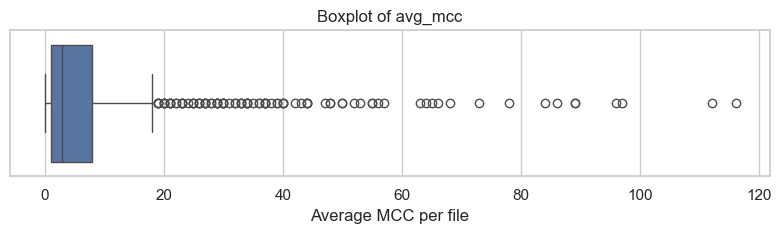

In [6]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 2.5))
sns.boxplot(
    x=meta_df["num_declarations_with_mcc"]
)

plt.xlabel("Average MCC per file")
plt.title("Boxplot of avg_mcc")

plt.tight_layout()
plt.show()

In [12]:
meta_df["avg_mcc_difficulty_bucket"] = pd.qcut(
    meta_df["avg_mcc"].rank(method="first"),
    q=5,
    labels=["1", "2", "3", "4", "5"],
    #include_lowest=True
)

num_cols = [
    "imports_count",
    "num_definitions",
    "num_declarations",
    "num_types",
    "num_declarations_with_mcc",
    "total_mcc",
    "max_mcc",
    "avg_mcc",
]

pearson = meta_df[num_cols].corr(method="pearson")["avg_mcc"].sort_values(ascending=False)
spearman = meta_df[num_cols].corr(method="spearman")["avg_mcc"].sort_values(ascending=False)

print("Pearson correlation vs avg_mcc:\n", pearson)
print("\nSpearman correlation vs avg_mcc:\n", spearman)

Pearson correlation vs avg_mcc:
 avg_mcc                      1.000000
max_mcc                      0.748596
total_mcc                    0.129465
num_declarations             0.072529
num_declarations_with_mcc    0.072132
num_definitions              0.051972
imports_count                0.046156
num_types                   -0.077594
Name: avg_mcc, dtype: float64

Spearman correlation vs avg_mcc:
 avg_mcc                      1.000000
max_mcc                      0.940514
total_mcc                    0.601640
num_declarations_with_mcc    0.439220
num_declarations             0.438319
num_definitions              0.343789
num_types                    0.017610
imports_count                0.006972
Name: avg_mcc, dtype: float64


In [13]:
bucket_col = "avg_mcc_difficulty_bucket"  # or q5 / fixed

summary = (
    meta_df.groupby(bucket_col, observed=True)[num_cols]
      .agg(["count", "mean", "median", "std"])
)

summary

imports_count                             \
                                  count      mean median       std   
avg_mcc_difficulty_bucket                                            
1                                   167  0.826347    0.0  1.624296   
2                                   166  0.921687    1.0  1.008996   
3                                   166  0.807229    0.0  1.032301   
4                                   166  0.777108    0.0  1.202908   
5                                   167  0.664671    0.0  1.159616   

                          num_definitions                               \
                                    count       mean median        std   
avg_mcc_difficulty_bucket                                                
1                                     167   6.544910    3.0  10.274372   
2                                     166   3.343373    3.0   2.847037   
3                                     166   9.524096    3.0  18.296780   
4                                     166  22.518072   14.0  22.147364   
5                                     167   5.017964    3.0   5.972299   

                          num_declarations             ... total_mcc  \
                                     count       mean  ...    median   
avg_mcc_difficulty_bucket                              ...             
1                                      167   4.514970  ...       1.0   
2                                      166   2.879518  ...       2.0   
3                                      166   8.463855  ...       2.0   
4                                      166  20.506024  ...      15.0   
5                                      167   4.257485  ...       5.0   

                                     max_mcc                             \
                                 std   count      mean median       std   
avg_mcc_difficulty_bucket                                                 
1                           8.065148     167  0.508982    1.0  0.501423   
2                           2.710634     166  1.000000    1.0  0.000000   
3                          18.499464     166  1.253012    1.0  0.512708   
4                          25.929460     166  2.554217    2.0  0.849285   
5                           8.988887     167  2.790419    2.0  1.221456   

                          avg_mcc                                
                            count      mean    median       std  
avg_mcc_difficulty_bucket                                        
1                             167  0.508982  1.000000  0.501423  
2                             166  1.000000  1.000000  0.000000  
3                             166  1.020152  1.000000  0.040625  
4                             166  1.287422  1.285714  0.093768  
5                             167  1.972986  1.888889  0.643372  

[5 rows x 32 columns]

In [ ]:
#meta_df.to_json(f"data/clean_datasets/mcc_stats_{VARIATION}_{VERSION}.jsonl", lines=True, orient="records")

In [23]:
meta_df["dominance"] = np.where(
    (meta_df["total_mcc"].notna()) & (meta_df["total_mcc"] > 0) & meta_df["max_mcc"].notna(),
    meta_df["max_mcc"] / meta_df["total_mcc"],
    np.nan
)


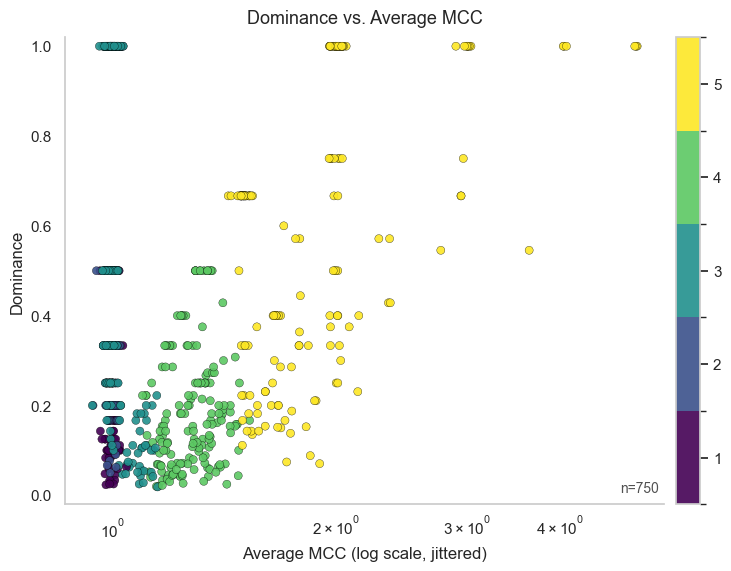

In [29]:
from matplotlib.colors import BoundaryNorm

# Assumes:
# - meta_df already has "dominance"
# - bucket_col is set (e.g., bucket_col = "difficulty_1_5")
# - plot_df is created as in your snippet

# Filter to valid rows (keep your variable names)
plot_df = meta_df.dropna(subset=["dominance", bucket_col]).copy()
plot_df[bucket_col] = plot_df[bucket_col].astype(int)

# --- Jitter (multiplicative so it behaves well under log scale) ---
rng = np.random.default_rng(0)
x = plot_df["avg_mcc"].to_numpy(dtype=float)
# ~1.5% jitter; tweak 0.015 up/down as needed
x_jitter = x * (1.0 + rng.normal(0.0, 0.015, size=len(x_jitter := x)))

# --- Plot settings ---
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

fig, ax = plt.subplots(figsize=(7.2, 5.6), constrained_layout=True)

bounds = np.arange(0.5, 5.6, 1)
norm = BoundaryNorm(bounds, ncolors=256)

sc = ax.scatter(
    x_jitter,
    plot_df["dominance"],
    c=plot_df[bucket_col],
    cmap="viridis",
    norm=norm,
    s=34,
    alpha=0.9,
    edgecolors="black",
    linewidths=0.25
)

ax.set_xscale("log")
ax.set_title("Dominance vs. Average MCC", pad=10)
ax.set_xlabel("Average MCC (log scale, jittered)")
ax.set_ylabel("Dominance")

ax.set_ylim(-0.02, 1.02)
ax.set_yticks(np.linspace(0, 1.0, 6))

#ax.grid(True, which="major", alpha=0.25)
ax.grid(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

cbar = fig.colorbar(sc, ax=ax, ticks=[1, 2, 3, 4, 5], fraction=0.05, pad=0.02)
cbar.set_label("")

ax.text(
    0.99, 0.02, f"n={len(plot_df)}",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=10, alpha=0.8
)


fig.savefig("plots/dominance_vs_avg_mcc_log_jitter.png", dpi=300, bbox_inches="tight")
fig.savefig("plots/dominance_vs_avg_mcc_log_jitter.pdf", bbox_inches="tight")

plt.show()